In [ ]:
!pip install mne wfdb scikit-learn matplotlib numpy pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import os
import numpy as np
import pandas as pd
import mne
import wfdb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, TimeDistributed, Flatten
from tensorflow.keras.utils import to_categorical


In [ ]:
# Download from PhysioNet using WFDB
# Create directory
!mkdir -p sleep-edf

# Download PSG (EEG) and Hypnogram (annotations)
!wget -P sleep-edf https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf
!wget -P sleep-edf https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf


--2025-03-25 02:30:19--  https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48338048 (46M) [application/octet-stream]
Saving to: ‘sleep-edf/SC4001E0-PSG.edf’

SC4001E0-PSG.edf    100%[===================>]  46.10M   355KB/s    in 2m 19s  

2025-03-25 02:32:39 (340 KB/s) - ‘sleep-edf/SC4001E0-PSG.edf’ saved [48338048/48338048]

--2025-03-25 02:32:39--  https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4620 (4.5K) [application/octet-stream]
Saving to: ‘sleep-edf/SC4001EC-Hypnogram.edf’

SC4001EC-Hypnogram. 100%[===================>]   4.51K  --.-KB/s    in 0s      



In [ ]:
raw = mne.io.read_raw_edf("sleep-edf/SC4001E0-PSG.edf", preload=True)
annotations = mne.read_annotations("sleep-edf/SC4001EC-Hypnogram.edf")
raw.set_annotations(annotations)

# Focus on EEG channel
raw.pick_channels(['EEG Fpz-Cz'])

# Convert to epochs (30-second segments)
events, _ = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events, tmin=0, tmax=30, baseline=None, preload=True)

# Extract data and labels
data = epochs.get_data()
labels = [ann['description'] for ann in raw.annotations if ann['description'].startswith('Sleep stage')]

# Clean up labels
stage_map = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,  # Combine stage 3 and 4 as N3
    'Sleep stage R': 4
}
labels = [stage_map.get(label, -1) for label in labels if 'Sleep stage' in label]
labels = np.array(labels[:len(data)])


Extracting EDF parameters from /content/sleep-edf/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-ff248f3e5de1>:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf("sleep-edf/SC4001E0-PSG.edf", preload=True)
<ipython-input-5-ff248f3e5de1>:1: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf("sleep-edf/SC4001E0-PSG.edf", preload=True)
<ipython-input-5-ff248f3e5de1>:1: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf("sleep-edf/SC4001E0-PSG.edf", preload=True)


Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<ipython-input-5-ff248f3e5de1>:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 3001 original time points ...
1 bad epochs dropped


In [ ]:
# Normalize
X = data.squeeze()  # shape: (samples, time_points)
X = (X - np.mean(X)) / np.std(X)

print("Before trim/reshape:", X.shape)

# Trim each sample to exactly 3000 time points
X_trimmed = np.array([x[:3000] for x in X])

# Reshape into (samples, 30 time steps, 100 features)
X = X_trimmed.reshape((X_trimmed.shape[0], 30, 100))

# One-hot encode labels
y = to_categorical(labels[:len(X)], num_classes=5)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Before trim/reshape: (153, 3001)


In [ ]:
model = Sequential([
    TimeDistributed(Conv1D(32, kernel_size=3, activation='relu'), input_shape=(X.shape[1], 100, 1)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 30, 98, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 30, 1568)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │         418,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 422,661 (1.61 MB)

 Trainable params: 422,661 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Reshape input to add feature channel
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3361 - loss: 1.5595 - val_accuracy: 0.4800 - val_loss: 1.3375
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step - accuracy: 0.4544 - loss: 1.3483 - val_accuracy: 0.3200 - val_loss: 1.3783
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step - accuracy: 0.3485 - loss: 1.3686 - val_accuracy: 0.3600 - val_loss: 1.3623
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.4202 - loss: 1.3332 - val_accuracy: 0.4800 - val_loss: 1.2846
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - accuracy: 0.5011 - loss: 1.2515 - val_accuracy: 0.4800 - val_loss: 1.2418
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - accuracy: 0.4731 - loss: 1.2597 - val_accuracy: 0.4800 - val_loss: 1.2163
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.4731 - loss: 1.2312 - val_accuracy: 0.5200 - val_loss: 1.2283
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.5508 - loss: 1.2288 - val_accuracy: 0.5200 - val_loss: 1

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5806 - loss: 1.0272
Test Accuracy: 0.58


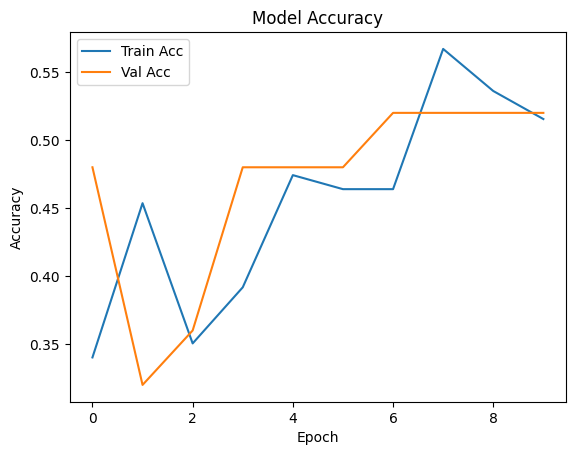

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
